In [2]:
from __future__ import print_function
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import pandas as pd
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles

## Three visits in 2 filters with specified filter pair and time gap


for Fast transients identification

In [3]:
import itertools

In [4]:
from lsst.sims.maf.metrics import BaseMetric


In [29]:
opsimdb = "baseline2018a"
opsimdb = "pontus_2564"
opsdb = db.OpsimDatabase(opsimdb + '.db')


In [56]:
class threeVisitsWColorMetric11(BaseMetric):
        

    def __init__(self, metricName="threevisits metric ", 
                 filterCol='filter', nightCol='night', 
                 mjdCol='observationStartMJD', dt1=0.5/24, dt2=1.5/24,
                 filters='gi', nVisitsMin=3, **kwargs):
        '''
        Calculates fields for which there are 3 visits in 2 filters with color within dt1 
        and shape at least separated by dt2
        
        returns 1 if the conditionas are all verified for the data slice, -666 otherwise
        default: dt1 30 min dt2 1.5 hours
        default filters y+g (cause there are a few)'''
        
        # Pass the same bins to the plotter.                                                      
        self.metricName = metricName
        self.mjdCol = mjdCol
        self.nightCol = nightCol
        self.filterCol = filterCol        
        self.nVisitsMin = nVisitsMin
        self.dt1 = dt1
        self.dt2 = dt2
        self.filters = (filters[0], filters[1])
        super(threeVisitsWColorMetric11, 
              self).__init__(col=[self.mjdCol, 
                                self.nightCol, 
                                self.filterCol], 
                                metricDtype='int', 
                                units='Fraction', 
                                **kwargs)

    def run(self, dataSlice, slicePoint=None):
        mins = [99, 99]
        maxs = [-99, -99]
        sorting = np.argsort(dataSlice[self.mjdCol])
        dataSlice = dataSlice[sorting]
        #count the observations within a night for each slice
        n, counts = np.unique(dataSlice[self.nightCol], return_counts=True)
        #print(dataSlice)
        allslices = len(n)
        minobs = n[counts >= 3]
        #print(n, counts, minobs)
        dt1, dt2, filtshape = 100, -1, 'x'

        metricval = 0
        f = open(self.metricName+".csv", "a")
        #iterate over nights with more than 3 observations
        for i,night in enumerate(minobs):
            #this is a night with >=3 observations
            good = dataSlice[self.nightCol] == night
            
            #check if it has 2 filters at least
            n, count = np.unique(dataSlice[self.filterCol][good], 
                                 return_counts=True)
            if len(n) > 1:
                #print(dataSlice[self.filterCol][good])
                #print(n, count)
                #obs with filter 1
                #print (n, count)
                f0 = dataSlice[self.filterCol][good] == self.filters[0]
                #obs with filter 2
                f1 = dataSlice[self.filterCol][good] == self.filters[1]
                
                if f0.sum() == 0 or f1.sum() == 0:
                    metricval = 0.
                    return metricval
                
                if f0.sum() > 1:
                    #max gap with same filter
                    dt2 = dataSlice[self.mjdCol][good][f0][-1] - \
                               dataSlice[self.mjdCol][good][f0][0]
                    #print("dt2", dt2)
                    filtshape = self.filters[0]
                if f1.sum() > 1:
                    #max gap with same filter
                    _tmp = dataSlice[self.mjdCol][good][f1][-1] - \
                               dataSlice[self.mjdCol][good][f1][0]
                    #print("other dt2", _tmp)
                    if  _tmp > dt2:
                            filtshape = self.filters[1]
                            dt2 = _tmp
                dt1 = np.min([np.abs(t1-t2) for t1 in dataSlice[self.mjdCol][good][f0] 
                             for t2 in dataSlice[self.mjdCol][good][f1]])

                f.write("%s,%d,%s,%d,%.3f,%.3f\n"%(
                    self.filters[0], f0.sum(), 
                      self.filters[1], f1.sum(), 
                         dt1, dt2))
                #print (dt1 , "(", self.dt1, ")", dt2, "(", self.dt2, ")", filtshape)
               
            
                #see if obs verify  gap min and max conditions
                if dt1 <= self.dt1 and dt2 >= self.dt2:
                    metricval += 1.0
        f.close()
        #print(metricval)
        return metricval #/ allslices
    
    def reducep(self, metricval):
        result = np.sum(metricval)
        return result


Exception: Redefining metric __main__.threeVisitsWColorMetric11! (there are >1 metrics with the same name)

In [ ]:
metricList = []
for i in list(itertools.combinations(['g','r','i','z'], 2)):
    pair = ''.join(i)
    metricList.append(threeVisitsWColorMetric11(filters=pair, 
                                            metricName="3visits" + pair))
    
slicer = slicers.HealpixSlicer(nside=8)
sqlconstraint = 'night < 365'
bDict={}
for i,metric in enumerate(metricList):
    bDict[i] = metricBundles.MetricBundle(
        metric, slicer, sqlconstraint)
    bDict[i].setPlotDict({'colorMin': 0.0, 'colorMax': 1.0})
    
bgroup = metricBundles.MetricBundleGroup(
    bDict, opsdb, outDir='visitsFastMetric', resultsDb=None)

bgroup.runAll()
bgroup.plotAll(closefigs=False)

Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes
Querying database SummaryAllProps with constraint night < 365 for columns ['night', 'observationStartMJD', 'fieldRA', 'fieldDec', 'filter']
Found 227468 visits
Running:  [0, 1, 2, 3, 4, 5]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night < 365" constraint now.


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/plots/spatialPlotters.py:303: UserWarning: Histogram range was single-valued; expanding default range.
  warnings.warn('Histogram range was single-valued; expanding default range.')
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: invalid value encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:66: UserWarning: Optimal bin calculation calculated NaN: returning 200
  warnings.warn('Optimal bin calculation calculated NaN: returning %i' %(nbinMax))
/home/docmaf/stack/stack/miniconda3-4.5.4-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/rotator.py:475: RuntimeWarning: invalid value encountered in double_scalars
  ang[0, :] = np.arccos(vz / r)


monopole: 0  dipole: lon: 0, lat: nan, amp: 0


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/plots/spatialPlotters.py:303: UserWarning: Histogram range was single-valued; expanding default range.
  warnings.warn('Histogram range was single-valued; expanding default range.')
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: invalid value encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:66: UserWarning: Optimal bin calculation calculated NaN: returning 200
  warnings.warn('Optimal bin calculation calculated NaN: returning %i' %(nbinMax))
/home/docmaf/stack/stack/miniconda3-4.5.4-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/rotator.py:475: RuntimeWarning: invalid value encountered in double_scalars
  ang[0, :] = np.arccos(vz / r)


monopole: 0  dipole: lon: 0, lat: nan, amp: 0


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/plots/spatialPlotters.py:303: UserWarning: Histogram range was single-valued; expanding default range.
  warnings.warn('Histogram range was single-valued; expanding default range.')
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: invalid value encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:66: UserWarning: Optimal bin calculation calculated NaN: returning 200
  warnings.warn('Optimal bin calculation calculated NaN: returning %i' %(nbinMax))
/home/docmaf/stack/stack/miniconda3-4.5.4-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/rotator.py:475: RuntimeWarning: invalid value encountered in double_scalars
  ang[0, :] = np.arccos(vz / r)


monopole: 0  dipole: lon: 0, lat: nan, amp: 0


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/plots/spatialPlotters.py:303: UserWarning: Histogram range was single-valued; expanding default range.
  warnings.warn('Histogram range was single-valued; expanding default range.')
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: invalid value encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:66: UserWarning: Optimal bin calculation calculated NaN: returning 200
  warnings.warn('Optimal bin calculation calculated NaN: returning %i' %(nbinMax))
/home/docmaf/stack/stack/miniconda3-4.5.4-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/rotator.py:475: RuntimeWarning: invalid value encountered in double_scalars
  ang[0, :] = np.arccos(vz / r)


monopole: 0  dipole: lon: 0, lat: nan, amp: 0


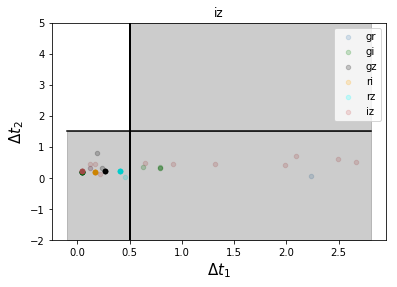

In [28]:
colors = {'gr':'SteelBlue', 'gi':'g', 'ri':'orange', 
          'rz':'cyan', 'iz':'IndianRed', 'gz':'k'}
import pylab as pl
ax = pl.figure().add_subplot(111)
for i in list(itertools.combinations(['g','r','i','z'], 2)):
    tmp = pd.read_csv("3visits" + ''.join(i) + ".csv", 
            header=None)
    tmp[4] = tmp[4]*24
    tmp[5] = tmp[5]*24
    tmp["c1"] = tmp[0].map({'g':1, 'r':2, 'i':3,'z':4})
    tmp["c2"] = tmp[2].map({'g':1, 'r':2, 'i':3,'z':4})
    ax = tmp.plot.scatter(x=4, y=5, alpha=0.2, color=colors[''.join(i)], 
                          ax=ax, label=''.join(i))
    ax.set_xlabel(r"$\Delta t_1$", fontsize=15)
    ax.set_ylabel(r"$\Delta t_2$", fontsize=15)
    ylim = (-2,5)
    
    ax.set_ylim(ylim)
    ax.plot([0.5,0.5], ylim, 'k')
xlim = ax.get_xlim()
ax.plot(xlim, [1.5,1.5], 'k')
ax.set_title(''.join(i))
pl.fill_between(xlim, [ylim[0], ylim[0]], [1.5,1.5], color='k', alpha=0.2)
pl.fill_between([0.5, xlim[1]], [ylim[1], ylim[1]], [1.5,1.5], color='k', alpha=0.2)
pl.savefig("3visits" + "_" + opsimdb + ".png")

In [14]:
!ls

3visits gi.csv
3visitsgi.csv
3visitsgi_.png
3visitsgi_baseline2018a.png
3visitsgr.csv
3visitsgr_.png
3visitsgr_baseline2018a.png
3visitsgz.csv
3visitsgz_.png
3visitsgz_baseline2018a.png
3visitsiz.csv
3visitsiz_.png
3visitsiz_baseline2018a.png
3visitsri.csv
3visitsri_.png
3visitsri_baseline2018a.png
3visitsrz.csv
3visitsrz_.png
3visitsrz_baseline2018a.png
ChipNames.ipynb
Compare Runs.ipynb
Complex Metrics.ipynb
Database Schema Changes.ipynb
DeepDrilling.ipynb
Dithers.ipynb
FTtransient_metric.ipynb
FastTransientsAlertMetric.ipynb
Getting_MAF_Help.ipynb
HybridCameraGeomStudies.ipynb
Index.ipynb
Introduction Notebook.ipynb
LightCurve
MAFCameraGeom.ipynb
PeriodicWithCrowd
Plotting Examples.ipynb
PullLightCurves.ipynb
README.md
RothDitherStacker Example.ipynb
RunComparison.ipynb
SDSSSlicer.ipynb
SequenceViz.ipynb
Slicers.ipynb
Spatial_Coordinates.ipynb
Stackers.ipynb
TestNotebook.ipynb
ThreeVisitsColor.ipynb
TransientMetric.ipynb
Transients
Untitled.ipynb
Untitled2.ipynb
VectorMetrics.ipynb


In [35]:
tmp.plot.scatter?

Signature: tmp.plot.scatter(x, y, s=None, c=None, **kwds)
Docstring:
Scatter plot

.. versionadded:: 0.17.0

Parameters
----------
x, y : label or position, optional
    Coordinates for each point.
s : scalar or array_like, optional
    Size of each point.
c : label or position, optional
    Color of each point.
**kwds : optional
    Keyword arguments to pass on to :py:meth:`pandas.DataFrame.plot`.

Returns
-------
axes : matplotlib.AxesSubplot or np.array of them
File:      ~/stack/python/miniconda3-4.5.4/envs/lsst-scipipe-10a4fa6/lib/python3.6/site-packages/pandas/plotting/_core.py
Type:      method


In [60]:
!mv 3visitsgi.csv potus_3visitsgi.cscv
